In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN, Birch
from collections import Counter

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # radius of the Earth in kilometers

    # convert decimal degrees to radians
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    # apply the haversine formula
    a = (
        math.sin(d_lat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = round(r * c, 2)

    return distance


def lat_to_m(lat, lon):
    # approximate radius of Earth in meters
    R = 6371000

    # convert latitude and longitude to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # calculate distance covered by one degree of latitude
    lat_dist = math.pi * R / 180.0

    return lat_dist * math.cos(lat_rad)


def lon_to_m(lat, lon):
    # approximate radius of Earth in meters
    R = 6371000

    # convert latitude and longitude to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # calculate distance covered by one degree of longitude
    lon_dist = math.pi * R / 180.0 * math.cos(lat_rad)

    return lon_dist

# Analyzing Crime in Brooklyn

## Crime Prevention and Law Enforcement

- In recent years, **crime prevention** and **law enforcement** have become increasingly **data-driven** fields. 

- Cities across the world are investing in systems to collect and analyze crime data to better understand patterns, identify hotspots, and allocate resources appropriately. 

- One such city is Brooklyn, which has an ambitious goal of reducing crime rates by 50% over the next decade.

## Data Science and Machine Learning Techniques

- To achieve this goal, the Brooklyn Police Department has turned to **data science** and **machine learning** techniques to develop new strategies for preventing crime before it happens. 

- As part of these efforts, we propose a novel algorithm that combines **geography-based clustering** and **association rule mining** to identify patterns in crime data. 

## Clustering and Association Rule Mining Algorithm

Our proposed algorithm involves two main steps:

1. Geographical Clustering Step: This step involves clustering crime reports geographically using both BIRCHSCAN and Mini Batch KMeans with HDBSCAN. These two clustering algorithms are capable of efficiently handling large datasets with high-dimensional features like those found in crime reports that contain latitude and longitude information. 

2. Association Rule Mining Step: Once the clustering is complete, this step involves combining the cluster information with victim data and applying an APRIORI algorithm to mine frequent patterns in crime. This allows us to identify patterns that are frequent both geographically and in terms of victimology (e.g., types of victims, times of day or week, etc.).

## Applicability and Benefits

- Our proposed algorithm seeks to provide a more comprehensive understanding of crime patterns in Brooklyn, and identify opportunities for new policing and prevention strategies. 

- Our algorithm is not only applicable to Brooklyn but can be adapted to other cities and urban areas around the world to help law enforcement agencies combat crime effectively.

- With its sophisticated clustering and association rule mining methodology, our algorithm provides a powerful tool for detecting patterns and trends in crime data, and will help enable proactive, data-driven approaches to crime prevention.

In [3]:
tb_nyc = pd.read_csv("data/NYPD_Complaint_Data_Historic.csv")

/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_52427/854018684.py:1: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tb_nyc = pd.read_csv("data/NYPD_Complaint_Data_Historic.csv")


# Data Exploration

In [4]:
tb_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7825499 entries, 0 to 7825498
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         int64  
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  float64
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX          

In [5]:
tb_nyc.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,506547392,03/29/2018,20:30:00,NaN,NaN,32.0,03/30/2018,351,CRIMINAL MISCHIEF & RELATED OF,254.0,...,NaN,NaN,40.810877,-73.941064,"(40.810877241, -73.941064151)",PATROL BORO MAN NORTH,NaN,25-44,WHITE,F
1,629632833,02/06/2018,23:15:00,NaN,NaN,52.0,02/07/2018,341,PETIT LARCENY,333.0,...,F,NaN,40.873671,-73.908014,"(40.873671035, -73.908013649)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,D
2,787203902,11/21/2018,00:15:00,11/21/2018,00:20:00,75.0,11/21/2018,341,PETIT LARCENY,321.0,...,F,NaN,40.651782,-73.885457,"(40.651782232, -73.885456761)",PATROL BORO BKLYN NORTH,NaN,UNKNOWN,UNKNOWN,D
3,280364018,06/09/2018,21:42:00,06/09/2018,21:43:00,10.0,06/10/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,M,NaN,40.759310,-73.994706,"(40.759310399, -73.994706072)",PATROL BORO MAN SOUTH,NaN,18-24,WHITE HISPANIC,F
4,985800320,11/10/2018,19:40:00,11/10/2018,19:45:00,19.0,11/10/2018,341,PETIT LARCENY,333.0,...,F,NaN,40.764536,-73.970728,"(40.764535539, -73.970728388)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,D


In [6]:
tb_nyc["OFNS_DESC"].value_counts()

OFNS_DESC
PETIT LARCENY                      1331246
HARRASSMENT 2                      1020122
ASSAULT 3 & RELATED OFFENSES        822614
CRIMINAL MISCHIEF & RELATED OF      789690
GRAND LARCENY                       679846
                                    ...   
FORTUNE TELLING                         12
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
KIDNAPPING AND RELATED OFFENSES          3
UNDER THE INFLUENCE OF DRUGS             3
Name: count, Length: 71, dtype: int64

In [7]:
tb_nyc["PD_DESC"].value_counts()

PD_DESC
ASSAULT 3                         676780
HARASSMENT,SUBD 3,4,5             668605
LARCENY,PETIT FROM STORE-SHOPL    402081
AGGRAVATED HARASSMENT 2           390612
HARASSMENT,SUBD 1,CIVILIAN        351525
                                   ...  
SMOKING TRANSPORTATION FACILIT         1
ABORTION 2, 1, SELF                    1
EDUCATION LAW,STREET TRADE             1
ANARCHY,CRIMINAL                       1
ENVIRONMENTAL CONTROL BOARD            1
Name: count, Length: 422, dtype: int64

In [8]:
tb_nyc[["VIC_AGE_GROUP", "VIC_SEX", "VIC_RACE"]].value_counts()

VIC_AGE_GROUP  VIC_SEX  VIC_RACE      
25-44          F        BLACK             549455
UNKNOWN        D        UNKNOWN           405848
25-44          F        WHITE HISPANIC    359318
UNKNOWN        E        UNKNOWN           327113
25-44          M        BLACK             322889
                                           ...  
-936           M        BLACK                  1
-937           F        BLACK                  1
-938           M        UNKNOWN                1
                        WHITE                  1
901            M        UNKNOWN                1
Name: count, Length: 568, dtype: int64

In [9]:
tb_nyc["BORO_NM"].value_counts()

BORO_NM
BROOKLYN         2313143
MANHATTAN        1882292
BRONX            1693981
QUEENS           1561712
STATEN ISLAND     361891
Name: count, dtype: int64

## Transforming Columns

In [10]:
tb_nyc.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

### Date Columns

In [11]:
tb_nyc["CMPLNT_FR_DT"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7825499 entries, 0 to 7825498
Series name: CMPLNT_FR_DT
Non-Null Count    Dtype 
--------------    ----- 
7824844 non-null  object
dtypes: object(1)
memory usage: 59.7+ MB


In [12]:
tb_nyc["CMPLNT_FR_DATE"] = pd.to_datetime(
    tb_nyc["CMPLNT_FR_DT"], format="%m/%d/%Y", errors="coerce"
)
tb_nyc["CMPLNT_TO_DATE"] = pd.to_datetime(
    tb_nyc["CMPLNT_TO_DT"], format="%m/%d/%Y", errors="coerce"
)

## Cleaning outliers and defining date horizon

In [13]:
tb_nyc = tb_nyc.dropna(subset=["CMPLNT_FR_DATE", "Latitude", "Longitude"])
mask_xxi = (
    (tb_nyc["CMPLNT_FR_DATE"].dt.year > 2009) # Filtering 2010-Present
    & (tb_nyc["BORO_NM"] == "BROOKLYN") # Filtering Brooklyn
    & (tb_nyc["LAW_CAT_CD"] != "FELONY") # Only Felonies and Misdemeanors
    & (tb_nyc["VIC_SEX"].isin(["M", "F"])) # Only crimes against individuals (not business nor PYNC)
    & (tb_nyc["JURISDICTION_CODE"] == 0) # Only crimes handled by NYPD
    & (tb_nyc["CRM_ATPT_CPTD_CD"] == "COMPLETED") # Only completed crimes
    
)
print(
    f"Filtered {np.sum(~mask_xxi)/len(~mask_xxi)*100:.2f}% of the data."
)
print(
    f"{np.sum(mask_xxi)} lines remaining."
)
tb_nyc = tb_nyc.loc[mask_xxi, :]
mask_outlier_pos = (
    (tb_nyc["Latitude"] < np.quantile(tb_nyc["Latitude"], 0.99))
    & (tb_nyc["Latitude"] > np.quantile(tb_nyc["Latitude"], 0.01))
    & (tb_nyc["Longitude"] < np.quantile(tb_nyc["Longitude"], 0.99))
    & (tb_nyc["Longitude"] > np.quantile(tb_nyc["Longitude"], 0.01))
)
print(
    f"Excluded {np.sum(~mask_outlier_pos)/len(mask_outlier_pos)*100:.2f}% of the data over spatial horizon (outliers)."
)
tb_nyc_model = tb_nyc.loc[(mask_xxi) & (mask_outlier_pos), :].copy()

Filtered 88.23% of the data.
918632 lines remaining.
Excluded 4.04% of the data over spatial horizon (outliers).


In [14]:
del tb_nyc

## Cleaning Categorical Variables

In [15]:
crime_vars = [
    "OFNS_DESC",
    "PREM_TYP_DESC",
    "PARKS_NM",
    "HADEVELOPT",
    "VIC_AGE_GROUP",
    "VIC_RACE",
    "VIC_SEX",
]
tb_nyc_model["VIC_AGE_GROUP"] = np.where(
    tb_nyc_model["VIC_AGE_GROUP"] == "UNKNOWN", np.nan, tb_nyc_model["VIC_AGE_GROUP"]
)
tb_nyc_model["VIC_RACE"] = np.where(
    tb_nyc_model["VIC_RACE"] == "UNKNOWN", np.nan, tb_nyc_model["VIC_RACE"]
)
for var in crime_vars:
    tb_nyc_model[var] = tb_nyc_model[var].mask(
        tb_nyc_model[var].map(tb_nyc_model[var].value_counts(normalize=True)) < 0.01,
        np.nan,
    )

## Centering latitude and longitude

In [16]:
tb_nyc_model["lat_demean"] = tb_nyc_model["Latitude"] - tb_nyc_model["Latitude"].mean()
tb_nyc_model["long_demean"] = (
    tb_nyc_model["Longitude"] - tb_nyc_model["Longitude"].mean()
)
tb_nyc_model["lat_meters"] = (
    tb_nyc_model.apply(lambda x: lat_to_m(x["Latitude"], x["Longitude"]), axis=1)
    * tb_nyc_model["lat_demean"]
)
tb_nyc_model["long_meters"] = (
    tb_nyc_model.apply(lambda x: lon_to_m(x["Latitude"], x["Longitude"]), axis=1)
    * tb_nyc_model["long_demean"]
)

## Creating distance-equivalent time measure

In [17]:
tb_nyc_model["months"] = (((tb_nyc_model["CMPLNT_FR_DATE"] - tb_nyc_model["CMPLNT_FR_DATE"].min())/pd.Timedelta(1, unit="D"))/30.4)
tb_nyc_model["year"] = tb_nyc_model["CMPLNT_FR_DATE"].dt.year

<Axes: xlabel='long_meters', ylabel='lat_meters'>

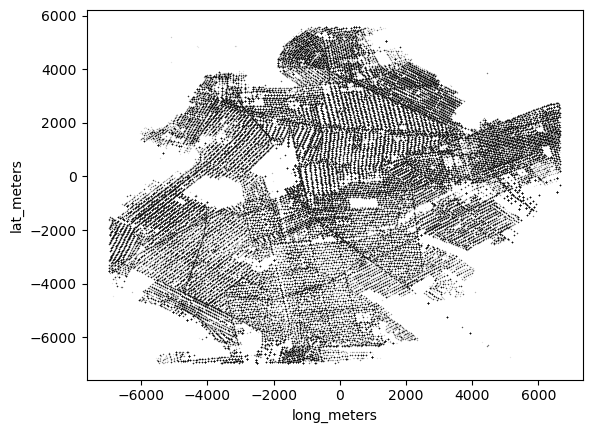

In [19]:
sns.scatterplot(
    data=tb_nyc_model, x="long_meters", y="lat_meters", color="black", alpha=0.1, s=1
)

# Geographical Clustering

## Creating DBSCAN model using the BIRCHSCAN methodology

https://sappg.ufes.br/tese_drupal/tese_15224_Dissertacao_FINAL.pdf

> At first, the empirical study of δ was carried out on synthetic data sets similar to Figure 8, with the objective of better understanding the behavior of the parameter. A fixed value was defined for ε and the value of δ was varied. It can be identified that for values greater than 1, every element is considered dense or noise. Thus, there is no connection within a radius ε between any centroids at the time of applying the data set generated by the output of BIRCH and applied in DBSCAN. And for values very close to 0, practically the entire data set is obtained, which is not an interesting option. Therefore, studies were observed for the open interval between 0 and 1. - *Translation by ChatGPT*

> A princípio o estudo empírico de δ foi realizado em conjuntos de dados sintéticos semelhante ao da Figura 8, com o objetivo de compreender melhor o comportamento do parâmetro. Um valor fixo foi definido para ε e variou-se o valor de δ. Pode-se identificar que para valores maiores que 1 todo elemento é considerado como denso ou ruído. Deste modo, não existe nenhuma conexão dentro de um raio ε entre nenhum centroide no momento da aplicação do conjunto de dados gerado pela saída do BIRCH e aplicado no DBSCAN. E para valores muito próximos a 0, obtém-se praticamente o conjunto de dados inteiro, não sendo uma opção interessante. Por isso, os estudos foram observados para o intervalo aberto entre 0 e 1. - *BIRCHSCAN: Um método de aproximação do DBSCAN para grandes conjuntos de dados, Ventorim - pg. 59*

*BIRCHSCAN* is a **hybrid** clustering approach that combines the advantages of two methods: **BIRCH** and **DBSCAN**. The BIRCH algorithm is **efficient** in handling very **large datasets**, while DBSCAN is particularly effective in discovering clusters with **arbitrary shapes**, as well as being less sensitive to **noise**.

BIRCHSCAN employs the BIRCH algorithm initially to identify clusters in large datasets and then applies DBSCAN on each cluster generated by BIRCH. By breaking the large dataset into smaller sub-clusters using BIRCH, DBSCAN can be applied more efficiently on these sub-clusters. In other words, BIRCH acts as a pre-clustering step, which significantly reduces the number of comparison operations required by DBSCAN, making it more **efficient** and **scalable**.

This approach is especially useful for **large datasets** as it reduces the computational complexity of DBSCAN algorithm and improves its **scalability**. Moreover, the BIRCHSCAN procedure can handle datasets with arbitrary shapes and sizes, as well as being less sensitive to noise, which makes it a **good option** for clustering a large dataset (1M+ observations) using DBSCAN.

### Implementing the BIRCHSCAN procedure

In [20]:
tb_nyc_model[['lat_meters', 'long_meters', "months"]].to_parquet("data/tb_nyc_model.parquet")

In [23]:
from sklearn.neighbors import NearestNeighbors

tb_radius = pd.DataFrame({"q" : np.arange(0.01, 0.99, 0.01)})
for radius in [50, 100, 150, 200, 250]:
    nn = NearestNeighbors(radius = radius)
    nn.fit(tb_nyc_model[["lat_meters", "long_meters"]])
    neigh = nn.radius_neighbors(tb_nyc_model[["lat_meters", "long_meters"]], return_distance=False)
    tb_radius[f"R_{radius}"] = np.quantile([i.shape for i in neigh], q = np.arange(0.01, 0.99, 0.01))
    del nn, neigh

(0.0, 1000.0)

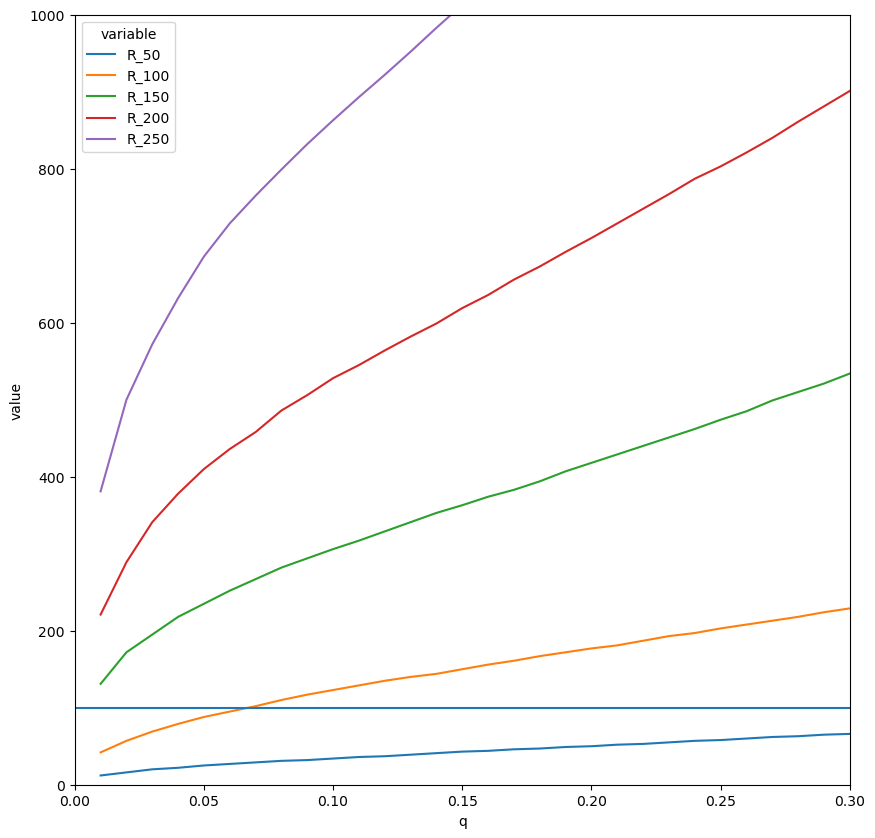

In [28]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.lineplot(tb_radius.melt(id_vars = "q"), x = "q", y = "value", hue = "variable", palette = "tab10")
ax.axhline(100)
ax.set_xlim(0, 0.3)
ax.set_ylim(0, 1000)

In [ ]:
tb_nyc_model["time_meters"] = tb_nyc_model["months"] * 100

In [32]:
min_samples = 90

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])
distances, index = nn.kneighbors(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])

(0.0, 500.0)

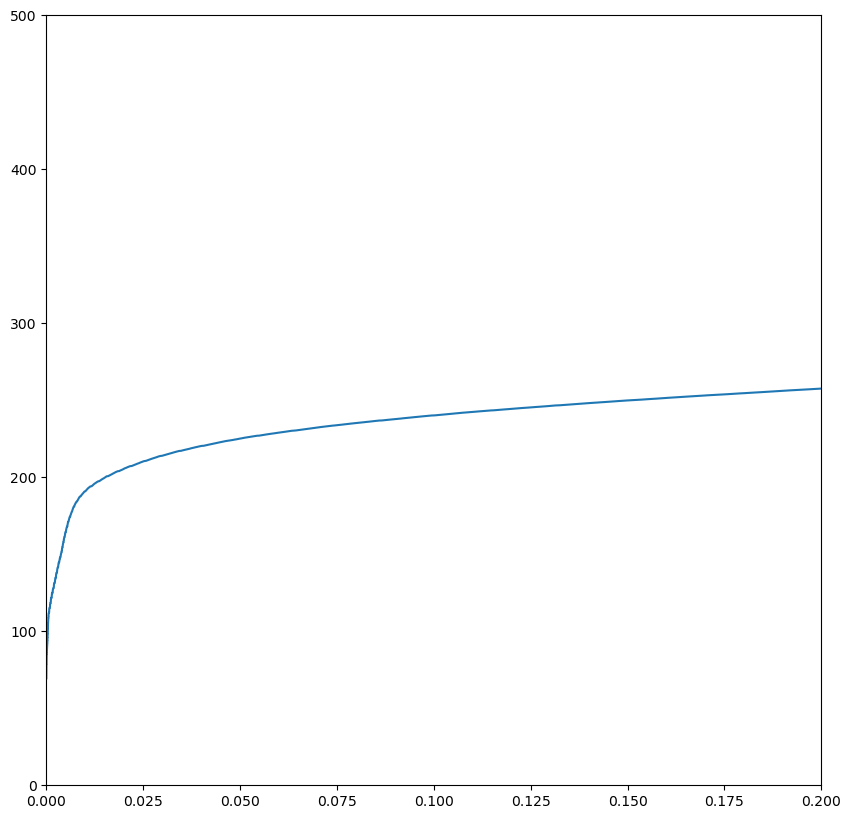

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.lineplot(y = np.sort(distances[:, -1]), x = np.arange(0, 1,1/len(distances[:, -1])))
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 500)

In [38]:
eps = 500
theta = 0.5

In [39]:
birch_fit = Birch(threshold=eps * theta, branching_factor=min_samples, n_clusters=None)
birch_fit.fit(tb_nyc_model[["lat_meters", "long_meters", "time_meters"]])
tb_nyc_model["birch_subcluster"] = birch_fit.labels_

In [ ]:
tb_birch = pd.DataFrame(
    birch_fit.subcluster_centers_, columns=["lat_meters", "long_meters"]
)
tb_birch["birch_subcluster"] = birch_fit.subcluster_labels_
tb_birch["weights"] = tb_birch["birch_subcluster"].map(dict(Counter(birch_fit.labels_)))
tb_birch["cluster_size_rank"] = tb_birch["weights"].rank(ascending=False)
tb_birch["cluster_size_distrib"] = (
    tb_birch["cluster_size_rank"] / tb_birch["cluster_size_rank"].max()
)
tb_birch = tb_birch.dropna()
num_sample_cluster = sum(tb_birch["weights"] > min_samples)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
sns.scatterplot(
    data=tb_birch,
    x="long_meters",
    y="lat_meters",
    color="black",
    size="weights",
    sizes=(2, 100),
    alpha=0.5,
    ax=ax[0][0],
)
sns.scatterplot(
    data=tb_nyc_model,
    x="long_meters",
    y="lat_meters",
    color="black",
    alpha=0.1,
    s=1,
    ax=ax[0][1],
)
ax[0][0].set_title("Sampled Locations with Associated Weights")
ax[0][1].set_title("Original Location Distribution")

sns.scatterplot(
    data=tb_birch[tb_birch["weights"] > min_samples],
    x="long_meters",
    y="lat_meters",
    color="black",
    size="weights",
    sizes=(2, 100),
    alpha=0.5,
    ax=ax[1][0],
)
sns.lineplot(
    data=tb_birch, x="cluster_size_rank", y="weights", color="black", ax=ax[1][1]
)
ax[1][1].axhline(min_samples, color="red", linestyle="--")
ax[1][0].set_title("Sampled Locations with Associated Weights (Core Samples)")
ax[1][1].set_title("Sample Weight Distribution")
ax[1][1].annotate(
    f"Core Samples\n{num_sample_cluster/tb_birch.shape[0]*100:.2f}%",
    xy=(num_sample_cluster, min_samples * 2),
)
fig.suptitle("Comparing Sampled & Original Locations", fontsize=16)

In [ ]:
db_fit = DBSCAN(eps=eps, min_samples=min_samples)
db_fit.fit(tb_birch[["lat_meters", "long_meters"]], sample_weight=tb_birch["weights"])
tb_birch["db_cluster"] = db_fit.labels_

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.scatterplot(
    data=tb_birch[tb_birch["db_cluster"] >= 0],
    x="long_meters",
    y="lat_meters",
    hue="db_cluster",
    palette="Spectral",
    alpha=0.9,
    s=5,
    ax=ax[0],
)
sns.scatterplot(
    data=tb_birch[tb_birch["db_cluster"] == -1],
    x="long_meters",
    y="lat_meters",
    size="weights",
    color="black",
    alpha=0.5,
    sizes=(2, 5),
    ax=ax[1],
)

In [ ]:
tb_nyc_cluster = tb_nyc_model.merge(
    tb_birch[["birch_subcluster", "db_cluster"]], on="birch_subcluster"
)
tb_nyc_cluster["geo_cluster"] = np.where(
    tb_nyc_cluster["db_cluster"] >= 0, tb_nyc_cluster["db_cluster"], np.nan
)
tb_nyc_cluster["geo_cluster"] = tb_nyc_cluster["geo_cluster"].astype(str)

In [ ]:
tb_nyc_cluster["birch_size"] = tb_nyc_cluster.groupby("birch_subcluster").transform('count')["CMPLNT_NUM"]